In [1]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Loading Data

In [2]:
df = pd.read_csv("../datasets/breast-cancer-data.csv",header=None)

df.set_axis(['Sample number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape',
              'Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli',
             'Mitoses','label'],axis=1,inplace=True)
# df.shape

In [3]:
# df['label'].value_counts()

# Data preprocessing

In [4]:
df.loc[df['Bare Nuclei']=='?','Bare Nuclei'] = np.nan

In [5]:
df.dropna(how='any',inplace=True)

In [6]:
y = df['label'].values

In [7]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
Y = labelEncoder.fit_transform(y)

In [8]:
X = df.drop(["Sample number","label"],axis=1)
# X_ = X.to_numpy()

In [9]:
feature_names = np.array(X.columns)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Train-Test split

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

# Training the Lgbm Model

In [12]:
d_train = lgb.Dataset(X_train,label=Y_train)

In [13]:
lgb_params = {'learning_rate':0.05, 'boosting_type':'gbdt',
              'objective':'binary',
              'metric':['auc','binary_logloss'],
              'num_leaves':10,
              'max_dept':100 }
lgbm_clf = lgb.train(lgb_params,d_train,50)

[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Info] Number of positive: 181, number of negative: 365
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 546, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331502 -> initscore=-0.701400
[LightGBM] [Info] Start training from score -0.701400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


# Testing the Lgbm Model

In [14]:
y_pred_lgbm = lgbm_clf.predict(X_test)

In [15]:
for i in range(0,len(X_test)):
    if y_pred_lgbm[i]>=0.5:
        y_pred_lgbm[i]=1
    else:
        y_pred_lgbm[i]=0

# Training the SVM model

In [16]:
from sklearn.svm import SVC
svm_clf = SVC(kernel="linear",random_state=4)
svm_clf.fit(X_train,Y_train)

SVC(kernel='linear', random_state=4)

# Testing the SVM model

In [17]:
y_pred_svm = svm_clf.decision_function(X_test)

In [18]:
for i in range(0,len(X_test)):
    if y_pred_svm[i]>=0.5:
        y_pred_svm[i]=1
    else:
        y_pred_svm[i]=0

# Accuracy score

In [19]:
from sklearn import metrics
print("Accuracy score of lgbm: ",metrics.accuracy_score(Y_test, y_pred_lgbm))
print("Accuracy score of svm: ",metrics.accuracy_score(Y_test, y_pred_svm))

Accuracy score of lgbm:  0.948905109489051
Accuracy score of svm:  0.9416058394160584


# AUC score

In [20]:
print("AUC scrore for lgbm: ",metrics.roc_auc_score(y_pred_lgbm,Y_test))
print("AUC scrore for SVM: ",metrics.roc_auc_score(y_pred_svm,Y_test))

AUC scrore for lgbm:  0.9548517520215634
AUC scrore for SVM:  0.94920814479638


# Confusion matrix (Lgbm)

In [21]:
import seaborn as sns

lgbm_confusionMatrix  = metrics.confusion_matrix(Y_test,y_pred_lgbm)
print(metrics.classification_report(Y_test,y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        79
           1       0.98      0.90      0.94        58

    accuracy                           0.95       137
   macro avg       0.95      0.94      0.95       137
weighted avg       0.95      0.95      0.95       137



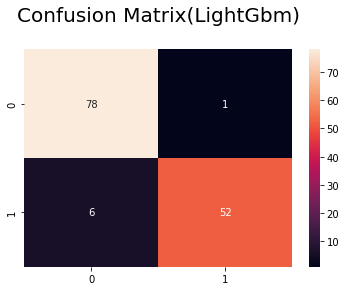

In [22]:
sns.heatmap(lgbm_confusionMatrix,annot=True)
plt.title('Confusion Matrix(LightGbm)\n', fontsize = 20) # title with fontsize 20
# plt.xlabel('', fontsize = 15) # x-axis label with fontsize 15
# plt.ylabel('', fontsize = 15) # y-axis label with fontsize 15
plt.show()

# Confusion matrix (SVM)

In [23]:
svm_confusionMatrix  = metrics.confusion_matrix(Y_test,y_pred_svm)
print(metrics.classification_report(Y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        79
           1       0.98      0.88      0.93        58

    accuracy                           0.94       137
   macro avg       0.95      0.93      0.94       137
weighted avg       0.94      0.94      0.94       137



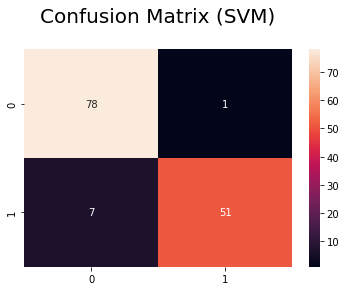

In [24]:
sns.heatmap(svm_confusionMatrix,annot=True)
plt.title('Confusion Matrix (SVM)\n', fontsize = 20)
plt.show()

# ROC Curve

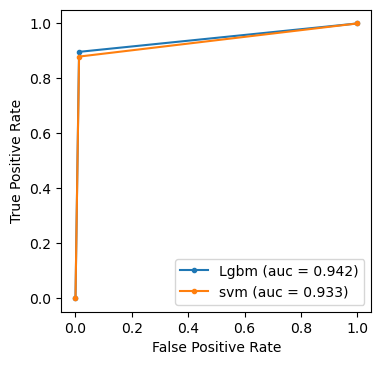

In [25]:
from sklearn.metrics import roc_curve, auc

lgbm_fpr,lgbm_tpr, threshold = roc_curve(Y_test, y_pred_lgbm)
auc_lgbm = auc(lgbm_fpr, lgbm_tpr)

svm_fpr,svm_tpr, threshold = roc_curve(Y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(4, 4), dpi=100)

plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='Lgbm (auc = %0.3f)' % auc_lgbm)
plt.plot(svm_fpr, svm_tpr, marker='.', label='svm (auc = %0.3f)' % auc_svm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()